In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch

from nldg.new.utils import gen_data, gen_data_v2
from nldg.new.rf import RF4DL
from nldg.new.rf import MaggingRF
from nldg.new.gp import MaximinGPR
from nldg.new.train_nn import train_model

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn as sns

## Solution 1: Modifying the weights of the trees

### Test distribution in the convex hull of the training distributions

In [19]:
dtr, dts = gen_data()
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

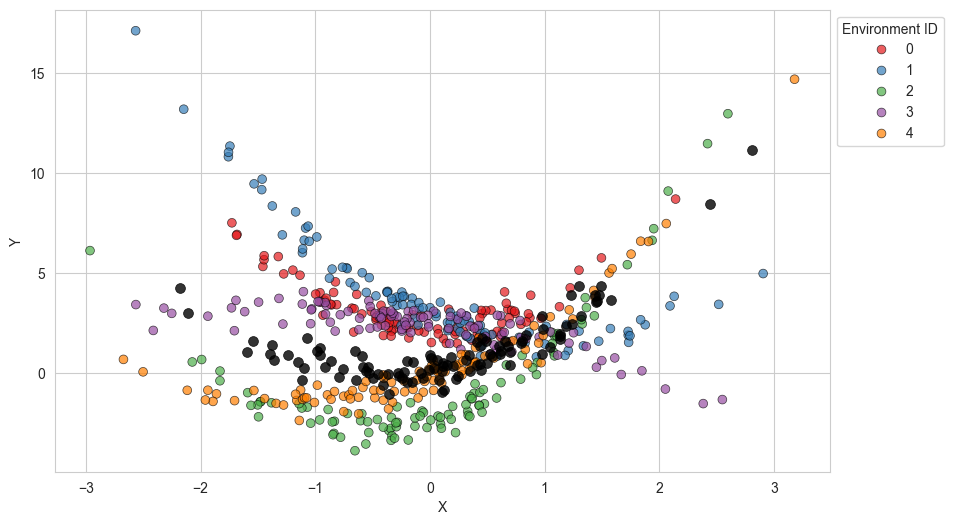

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [21]:
m_try = 1.0
rf = MaggingRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaggingRF()

In [22]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Xts)

In [23]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(3.9832806342821145, -0.28722681737683264)

In [24]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(3.596836690490757, -0.16234457745131148)

### Test distribution outside the convex hull of the train distributions

In [25]:
dtr, dts = gen_data(inhull=False)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

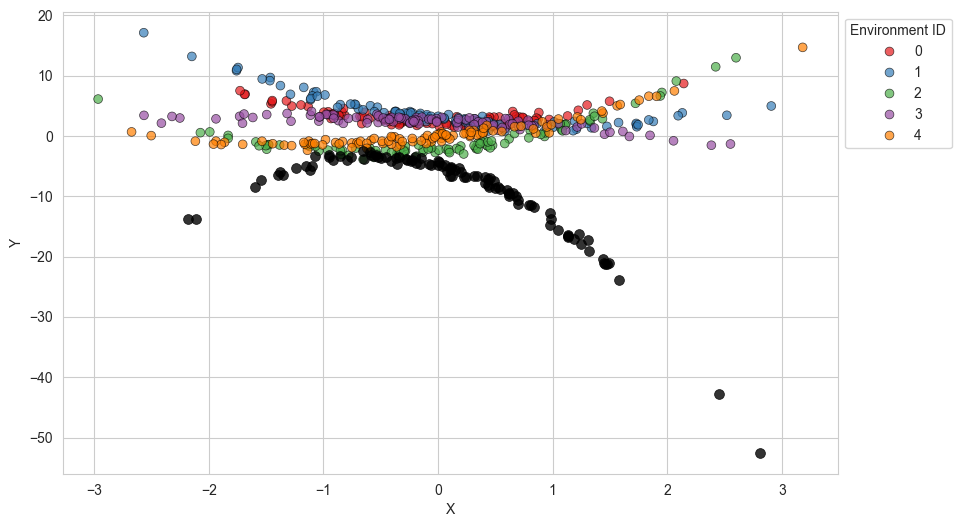

In [26]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

In [27]:
m_try = 1.0
rf = MaggingRF(n_estimators=50, random_state=42, max_features=m_try)
rf.fit(Xtr, Ytr)

MaggingRF()

In [28]:
preds = rf.predict(Xts)
wpreds, weights = rf.predict_maximin(Xtr, Xts)

In [29]:
mean_squared_error(Yts, wpreds), r2_score(Yts, wpreds)

(187.68142676353165, -2.197166016588613)

In [30]:
mean_squared_error(Yts, preds), r2_score(Yts, preds)

(191.59248329353687, -2.2637911336410554)

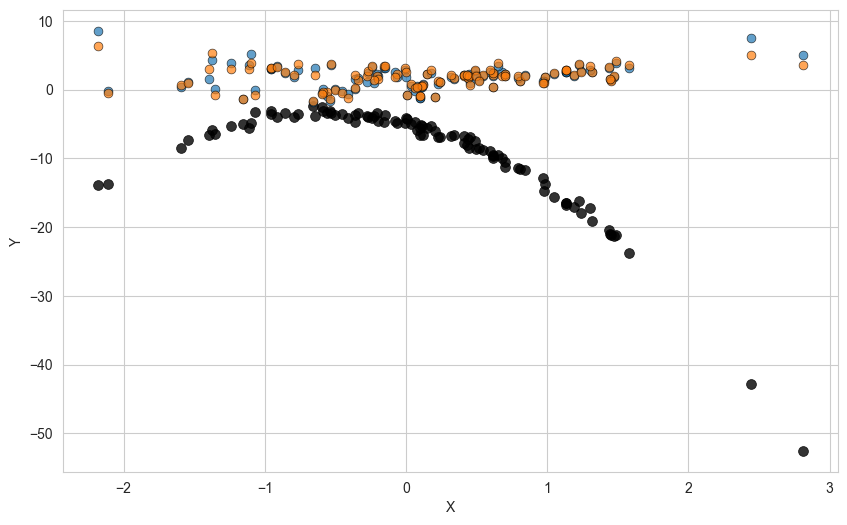

In [31]:
plt.figure(figsize=(10, 6))
dpr = pd.DataFrame({"X": Xts.ravel(), "Y": preds})
dwpr = pd.DataFrame({"X": Xts.ravel(), "Y": wpreds})
sns.scatterplot(data=dts, x="X", y="Y", color="black", 
                alpha=0.8, s=50, edgecolor="black")
sns.scatterplot(data=dpr, x="X", y="Y", color="#1f77b4",
                alpha=0.7, s=40, edgecolor="black")
sns.scatterplot(data=dwpr, x="X", y="Y", color="#ff7f0e",
                alpha=0.7, s=40, edgecolor="black")

plt.grid(True)
plt.show()

## Solution 2: Gaussian Process Regression

In [2]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

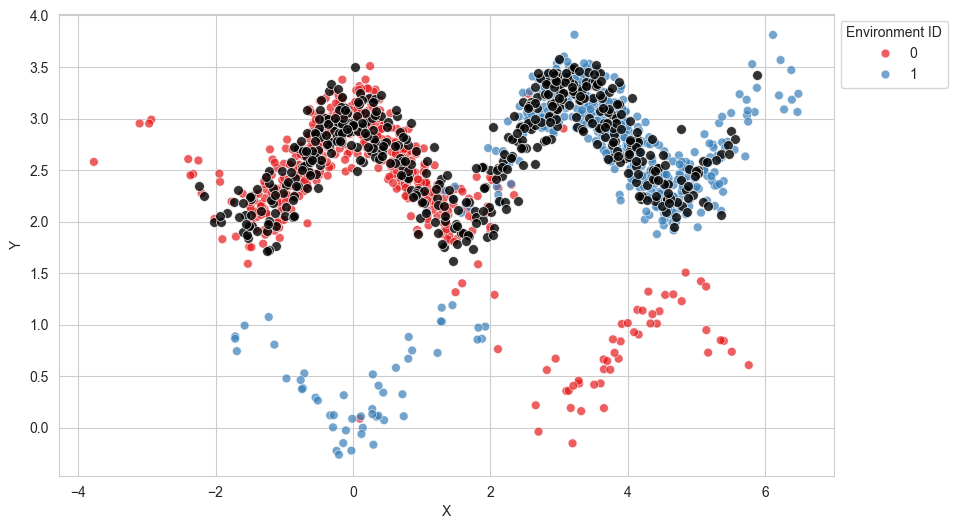

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=dtr, x="X", y="Y", hue="E", palette="Set1", alpha=0.7, s=40)
sns.scatterplot(data=dts, x="X", y="Y", color="black", alpha=0.8, s=50)

plt.legend(title="Environment ID", loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

### Maximin GPR

In [23]:
kernel = ConstantKernel() * RBF(length_scale=1.0) + ConstantKernel() * WhiteKernel(noise_level=1.0)
mgpr = MaximinGPR(kernel=kernel)
mgpr.fit(Xtr, Etr, Ytr)
Xtr_sorted = np.sort(Xtr, axis=0)
Xts_sorted = np.sort(Xts, axis=0)
mpreds = mgpr.predict(Xts)
mfitted = mgpr.predict(Xtr)

### Default GPR

In [24]:
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(Xtr, Ytr)
preds = gp.predict(Xts)
fitted = gp.predict(Xtr)

### Magging GPR

In [25]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    gpr = GaussianProcessRegressor(kernel=kernel)
    gpr.fit(Xtr_e, Ytr_e)
    preds_envs.append(gpr.predict(Xts_sorted))
    fitted_envs.append(gpr.predict(Xtr_sorted))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

In [26]:
dtr["X_sorted"] = Xtr_sorted
dts["X_sorted"] = Xts_sorted
dtr["mfitted"], dtr["fitted_mstd"] = mgpr.predict(Xtr_sorted, return_std=True)
dtr["fitted"], dtr["fitted_std"] = gp.predict(Xtr_sorted, return_std=True)
dts["mpreds"], dts["preds_mstd"] = mgpr.predict(Xts_sorted, return_std=True)
dts["preds"], dts["preds_std"] = gp.predict(Xts_sorted, return_std=True)
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds

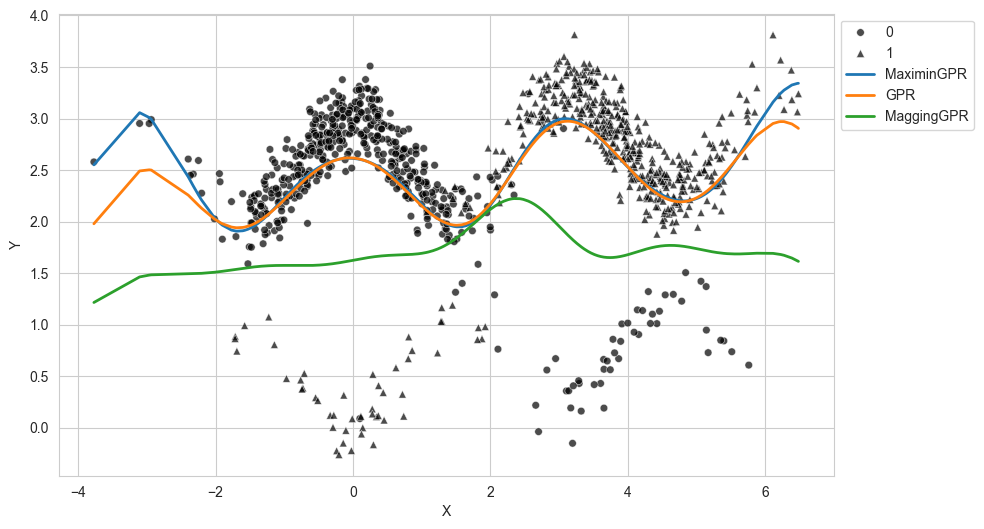

In [27]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinGPR")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="GPR")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingGPR")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

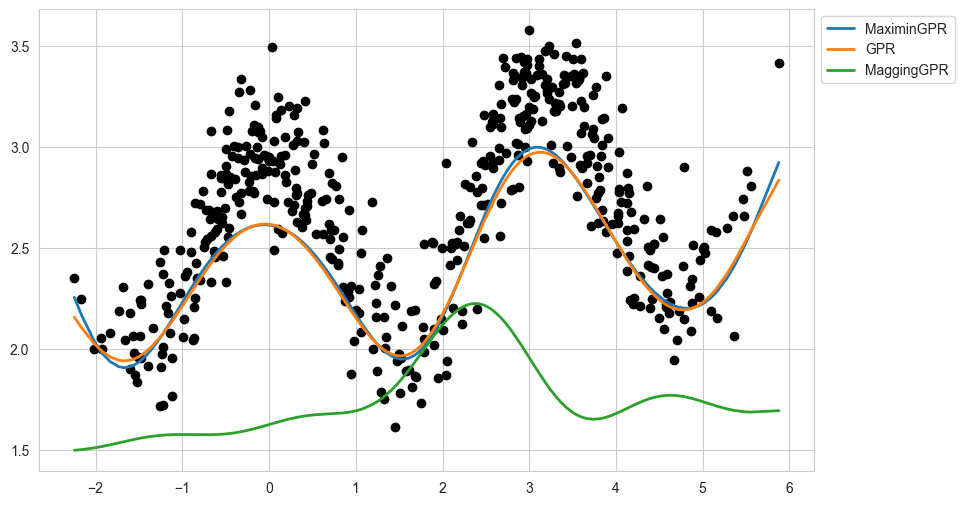

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinGPR")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="GPR")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingGPR")

method_legend = [line1, line2, line3]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## Solution 3: Neural Networks

In [29]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

In [36]:
scaler = StandardScaler()
X_train = scaler.fit_transform(Xtr)
X_test = scaler.transform(Xts)
X_train_sorted = np.sort(X_train, axis=0)
X_test_sorted = np.sort(X_test, axis=0)
X_train_tensor = torch.tensor(X_train_sorted, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sorted, dtype=torch.float32)

### Maximin NN

In [37]:
model = train_model(X_train, Ytr, Etr, epochs=200, verbose=False)
with torch.no_grad():
    mpreds = model(X_test_tensor).numpy()
    mfitted = model(X_train_tensor).numpy()

### Default NN

In [38]:
model = train_model(X_train, Ytr, Etr, epochs=200, verbose=False, default=True)
with torch.no_grad():
    preds = model(X_test_tensor).numpy()
    fitted = model(X_train_tensor).numpy()

### Magging NN

In [43]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = X_train[Etr == env]
    Ytr_e = Ytr[Etr == env]
    model = train_model(Xtr_e, Ytr_e, Etr[Etr == env], epochs=200, verbose=False, default=True)
    with torch.no_grad():
        preds_envs.append(model(X_test_tensor).numpy())
        fitted_envs.append(model(X_train_tensor).numpy())
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

In [45]:
dtr["X_transf"] = X_train
dts["X_transf"] = X_test
dtr["X_sorted"] = X_train_sorted.ravel()
dts["X_sorted"] = X_test_sorted.ravel()
dtr["mfitted"] = mfitted
dtr["fitted"] = fitted
dts["mpreds"] = mpreds
dts["preds"] = preds
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds

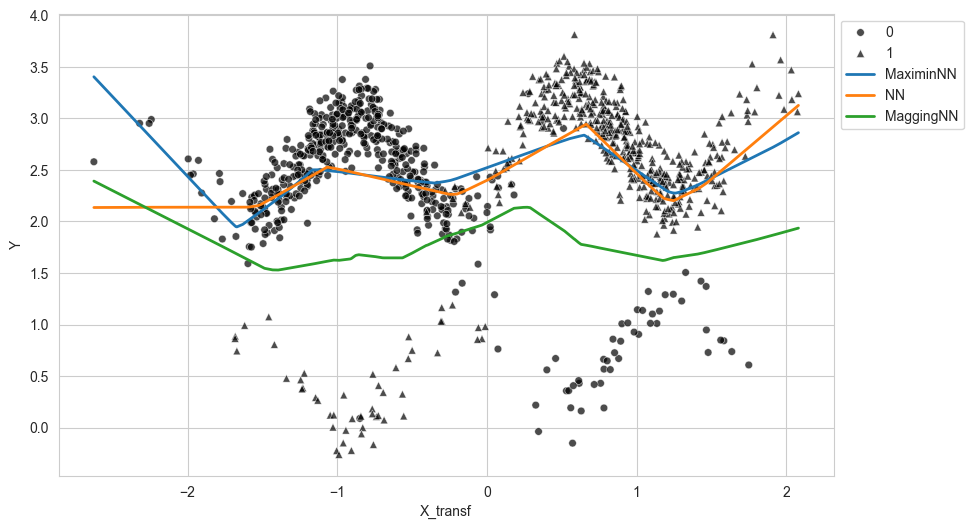

In [50]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X_transf", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinNN")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="NN")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingNN")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3]
method_legend = [line1, line2]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

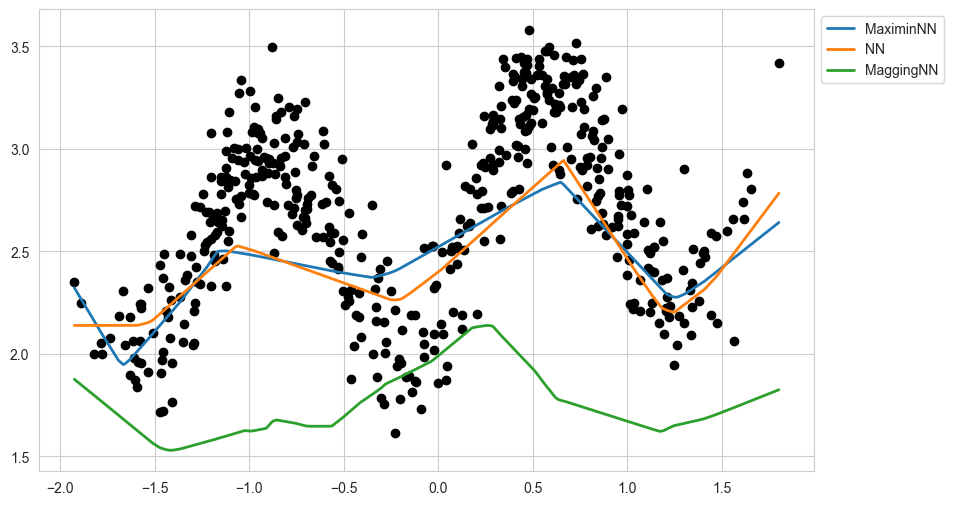

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X_transf"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinNN")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="NN")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingNN")

method_legend = [line1, line2, line3]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## Solution 4: Modifying the splitting criterion

In [2]:
dtr, dts = gen_data_v2(n_train=1000, n_test=500)
Xtr, Xts = np.array(dtr.drop(columns=['E', 'Y'])), np.array(dts.drop(columns=['E', 'Y']))
Ytr, Yts = np.array(dtr['Y']), np.array(dts['Y'])
Etr = np.array(dtr['E'])

### Maximin RF

In [3]:
mrf = RF4DL(criterion='maximin', n_estimators=50, min_samples_leaf=10)
mrf.fit(Xtr, Ytr, Etr)
Xtr_sorted = np.sort(Xtr, axis=0)
Xts_sorted = np.sort(Xts, axis=0)
mpreds = mrf.predict(Xts_sorted)
mfitted = mrf.predict(Xtr_sorted)

100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


### Default RF

In [4]:
rf = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
rf.fit(Xtr, Ytr, Etr)
preds = rf.predict(Xts_sorted)
fitted = rf.predict(Xtr_sorted)

100%|██████████| 50/50 [00:24<00:00,  2.07it/s]


### Magging RF

In [5]:
def objective(w: np.ndarray, F: np.ndarray) -> float:
    return np.dot(w.T, np.dot(F.T, F).dot(w))

n_envs = len(np.unique(Etr))
winit = np.array([1 / n_envs] * n_envs)
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
bounds = [[0, 1] for _ in range(n_envs)]

preds_envs = []
fitted_envs = []
for env in np.unique(Etr):
    Xtr_e = Xtr[Etr == env]
    Ytr_e = Ytr[Etr == env]
    Etr_e = Etr[Etr == env]
    rfm = RF4DL(criterion='mse', n_estimators=50, min_samples_leaf=10)
    rfm.fit(Xtr_e, Ytr_e, Etr_e)
    preds_envs.append(rfm.predict(Xts_sorted))
    fitted_envs.append(rfm.predict(Xtr_sorted))
preds_envs = np.column_stack(preds_envs)
fitted_envs = np.column_stack(fitted_envs)

wmag = minimize(objective, winit, args=(fitted_envs,), bounds=bounds, constraints=constraints,).x
wpreds = np.dot(wmag, preds_envs.T)
wfitted = np.dot(wmag, fitted_envs.T)

100%|██████████| 50/50 [00:06<00:00,  7.18it/s]


### Magging RF 2

In [6]:
rfm2 = MaggingRF(n_estimators=50, min_samples_leaf=10)
rfm2.fit(Xtr, Ytr)
wpreds2 = rfm2.predict(Xts_sorted)
wfitted2 = rfm2.predict(Xtr_sorted)

In [7]:
dtr["X_sorted"] = Xtr_sorted
dts["X_sorted"] = Xts_sorted
dtr["mfitted"] = mfitted
dtr["fitted"] = fitted
dts["mpreds"] = mpreds
dts["preds"] = preds
dtr["wfitted"] = wfitted
dts["wpreds"] = wpreds
dtr["wfitted2"] = wfitted2
dts["wpreds2"] = wpreds2

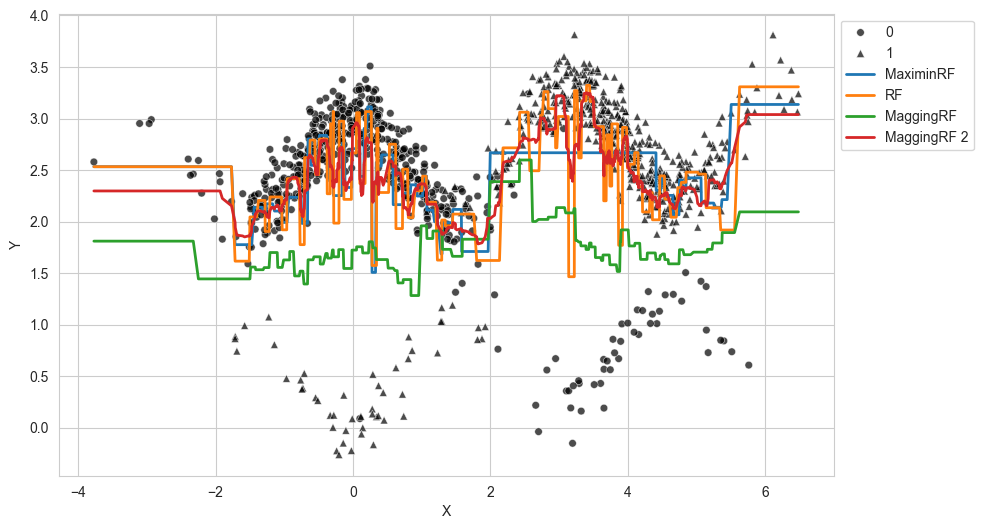

In [8]:
plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(data=dtr, x="X", y="Y", style="E", markers=['o', '^'], alpha=0.7, s=30, color='black')

line1, = plt.plot(dtr["X_sorted"], dtr["mfitted"], linewidth=2, label="MaximinRF")
line2, = plt.plot(dtr["X_sorted"], dtr["fitted"], linewidth=2, label="RF")
line3, = plt.plot(dtr["X_sorted"], dtr["wfitted"], linewidth=2, label="MaggingRF")
line4, = plt.plot(dtr["X_sorted"], dtr["wfitted2"], linewidth=2, label="MaggingRF 2")

handles, labels = scatter.get_legend_handles_labels()
method_legend = [line1, line2, line3, line4]

plt.legend(handles=handles + method_legend, labels=labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

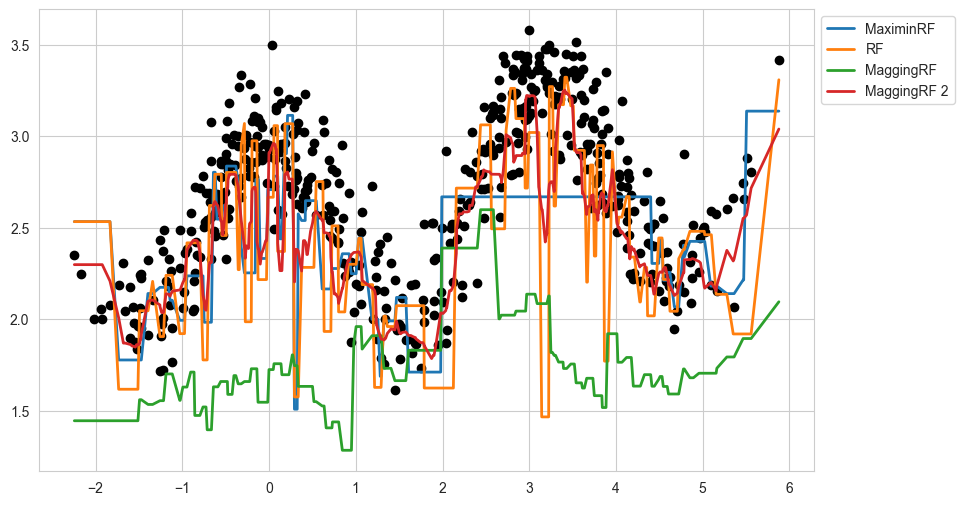

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(dts["X"], dts["Y"], color="black")
line1, = plt.plot(dts["X_sorted"], dts["mpreds"], linewidth=2, label="MaximinRF")
line2, = plt.plot(dts["X_sorted"], dts["preds"], linewidth=2, label="RF")
line3, = plt.plot(dts["X_sorted"], dts["wpreds"], linewidth=2, label="MaggingRF")
line4, = plt.plot(dts["X_sorted"], dts["wpreds2"], linewidth=2, label="MaggingRF 2")

method_legend = [line1, line2, line3, line4]

plt.legend(handles=method_legend, loc="upper left", bbox_to_anchor=(1, 1))

plt.grid(True)
plt.show()

## TEST

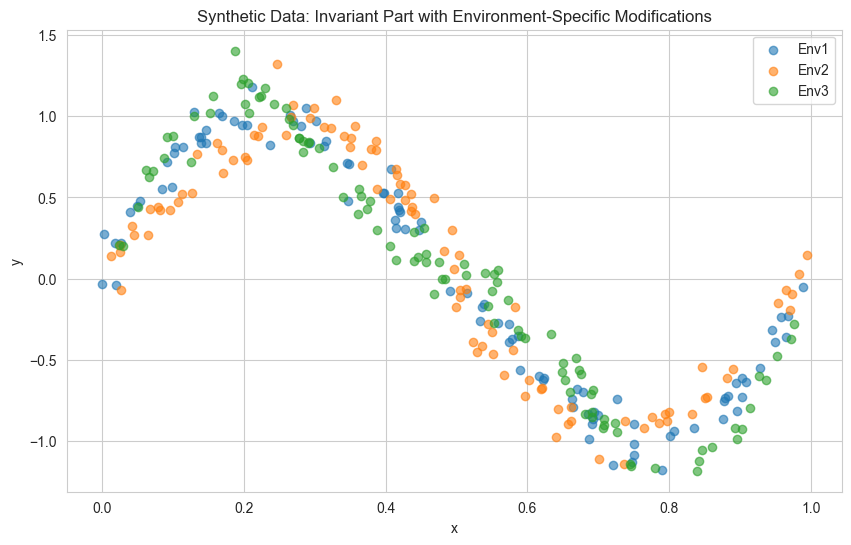

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def generate_invariant_data(n_samples=100, noise_std=0.1, random_state=None):
    """
    Generates the invariant component of the data:
      f(x) = sin(2*pi*x)
    """
    if random_state is not None:
        np.random.seed(random_state)
    X = np.random.uniform(0, 1, size=(n_samples, 1))
    invariant = np.sin(2 * np.pi * X)
    return X, invariant

def generate_environment_data(X, invariant, a, noise_std=0.1):
    """
    Adds an environment-specific modification:
      modification(x) = a * sin(4*pi*x)
    The overall response is:
      y = invariant + modification + noise
    """
    modification = a * np.sin(4 * np.pi * X)
    noise = np.random.normal(0, noise_std, size=X.shape)
    y = invariant + modification + noise
    return y

# Define parameters for each environment
environments = {
    'Env1': {'a': 0.1, 'n_samples': 100, 'random_state': 1},
    'Env2': {'a': -0.1, 'n_samples': 100, 'random_state': 2},
    'Env3': {'a': 0.3, 'n_samples': 100, 'random_state': 3},
}

# Dictionary to store generated data for each environment
data = {}

for env, params in environments.items():
    # Generate the invariant part
    X, invariant = generate_invariant_data(n_samples=params['n_samples'],
                                             noise_std=0.0,  # No noise for the invariant component
                                             random_state=params['random_state'])
    # Add the environment-specific modification along with noise
    y = generate_environment_data(X, invariant, a=params['a'], noise_std=0.1)
    data[env] = {'X': X, 'y': y}

# Optional: Plot the generated data for visualization
plt.figure(figsize=(10, 6))
for env, dataset in data.items():
    plt.scatter(dataset['X'], dataset['y'], label=env, alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Synthetic Data: Invariant Part with Environment-Specific Modifications')
plt.legend()
plt.show()

# The generated data is stored in the 'data' dictionary for each environment.


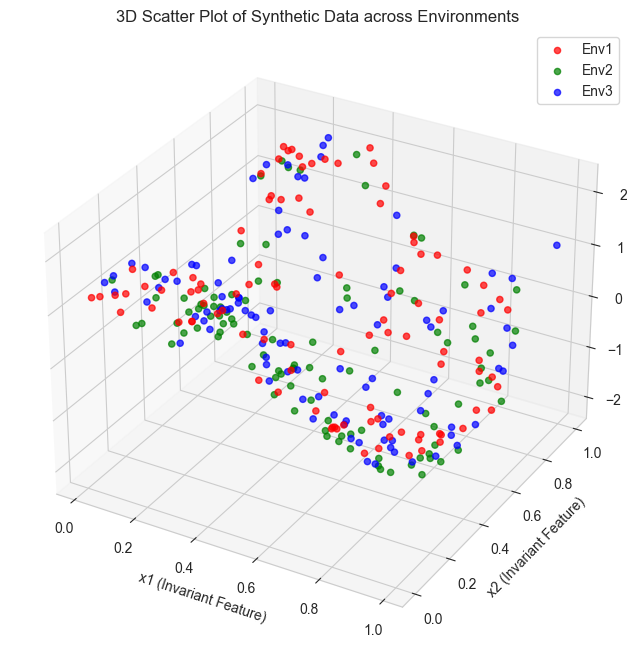

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

def generate_data_highdim(n_samples=100, beta=0.0, noise_std=0.1, random_state=None):
    """
    Generates synthetic 3D feature data:
      - Invariant component: sin(2π * x1) + cos(2π * x2)
      - Environment-specific effect: beta * x3
      - Overall response: invariant component + environment effect + Gaussian noise
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Generate features uniformly in [0, 1]
    X = np.random.uniform(0, 1, size=(n_samples, 3))
    
    # Invariant part based on x1 and x2
    invariant = np.sin(2 * np.pi * X[:, 0]) + np.cos(2 * np.pi * X[:, 1])
    
    # Environment-specific modification from x3
    env_effect = beta * X[:, 2]
    
    # Overall response with added Gaussian noise
    y = invariant + env_effect + np.random.normal(0, noise_std, size=n_samples)
    return X, y

# Define parameters for each environment
env_params = {
    'Env1': {'beta': 0.1, 'n_samples': 100, 'random_state': 1},
    'Env2': {'beta': -0.2, 'n_samples': 100, 'random_state': 2},
    'Env3': {'beta': 0.3, 'n_samples': 100, 'random_state': 3},
}

# Set up the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define colors for each environment
colors = {'Env1': 'red', 'Env2': 'green', 'Env3': 'blue'}

# Generate data for each environment and add to the plot
for env, params in env_params.items():
    X, y = generate_data_highdim(n_samples=params['n_samples'],
                                 beta=params['beta'],
                                 noise_std=0.1,
                                 random_state=params['random_state'])
    ax.scatter(X[:, 0], X[:, 1], y, color=colors[env], label=env, alpha=0.7)

# Set labels and title
ax.set_xlabel('x1 (Invariant Feature)')
ax.set_ylabel('x2 (Invariant Feature)')
ax.set_zlabel('Response y')
ax.set_title('3D Scatter Plot of Synthetic Data across Environments')
ax.legend()

plt.show()
